<a href="https://colab.research.google.com/github/spavliga/64061_spavliga/blob/main/Assignment%202-%20Part%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=500)
copy_images("validation")
copy_images("test")

 train/cats: 500 images copied
 train/dogs: 500 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
  "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
  "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)


Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
  ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
filepath="feature_extraction_with_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.7762 - loss: 46.4393 - val_accuracy: 0.9190 - val_loss: 12.9149
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.9474 - loss: 6.2648 - val_accuracy: 0.9540 - val_loss: 7.2780
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - accuracy: 0.9599 - loss: 5.2687 - val_accuracy: 0.9620 - val_loss: 6.2428
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - accuracy: 0.9509 - loss: 5.7735 - val_accuracy: 0.9610 - val_loss: 5.8361
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.9722 - loss: 3.7807 - val_accuracy: 0.9670 - val_loss: 4.4352
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.9649 - loss: 2.8386 - val_accuracy: 0.9620 - val_loss: 5.5036
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.9547 - loss: 4.6847 - val_accuracy: 0.9680 - val_loss: 4.7047
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.9725 - loss: 2.0309 - val_accura

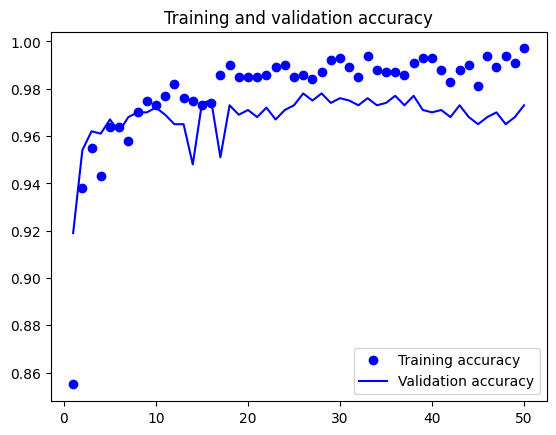

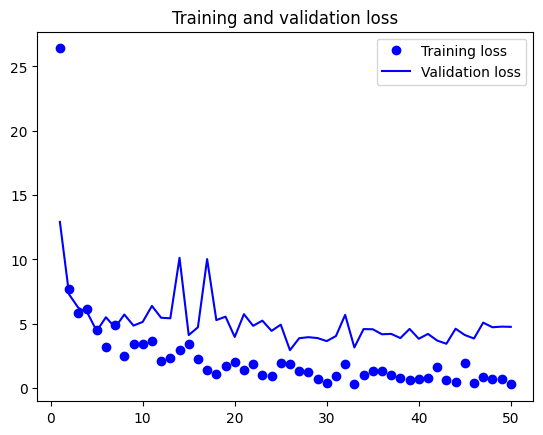

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
 test_model = keras.models.load_model(
 "feature_extraction_with_data_augmentation.keras")
 test_loss, test_acc = test_model.evaluate(test_dataset)
 print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9703 - loss: 5.5387
Test accuracy: 0.976


accuracy did appear to increase.

upping to 750 without data augmentation-

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=750)
copy_images("validation")
copy_images("test")

 train/cats: 750 images copied
 train/dogs: 750 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 1500 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
      preprocessed_images = keras.applications.vgg16.preprocess_input(images)
      features = conv_base.predict(preprocessed_images)
      all_features.append(features)
      all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
train_features.shape

(1500, 5, 5, 512)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
      optimizer="rmsprop",
      metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8861 - loss: 18.1188 - val_accuracy: 0.9450 - val_loss: 10.0710
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9727 - loss: 5.1535 - val_accuracy: 0.9670 - val_loss: 5.1869
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9906 - loss: 0.8698 - val_accuracy: 0.9640 - val_loss: 5.6827
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9882 - loss: 1.1067 - val_accuracy: 0.9710 - val_loss: 4.6366
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9947 - loss: 0.9463 - val_accuracy: 0.9740 - val_loss: 4.1928
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9925 - loss: 1.7030 - val_accuracy: 0.9650 - val_loss: 8.1260
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9909 - loss: 1.3525 - val_accuracy: 0.9680 - val_loss: 5.3221
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9952 - loss: 0.6329 - val_accuracy: 0.9670 - val_

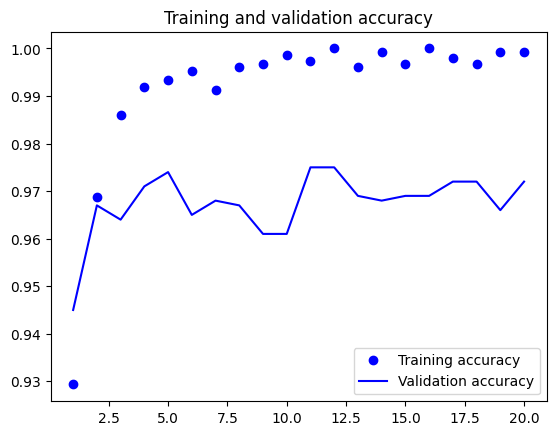

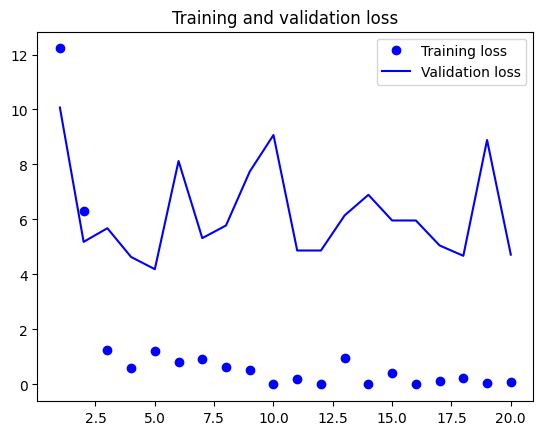

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")

test_features, test_labels = get_features_and_labels(test_dataset)

test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Higher accuracy than 500

with data augmentation-

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=750)
copy_images("validation")
copy_images("test")

 train/cats: 750 images copied
 train/dogs: 750 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
  "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
  "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 0


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)


Found 1500 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
data_augmentation = keras.Sequential(
    [
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
filepath="feature_extraction_with_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 350ms/step - accuracy: 0.8156 - loss: 50.8276 - val_accuracy: 0.9590 - val_loss: 5.8547
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - accuracy: 0.9339 - loss: 7.3858 - val_accuracy: 0.9670 - val_loss: 6.0317
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: 0.9511 - loss: 5.6329 - val_accuracy: 0.9650 - val_loss: 5.7076
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 234ms/step - accuracy: 0.9701 - loss: 3.2372 - val_accuracy: 0.9740 - val_loss: 4.1385
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.9740 - loss: 3.3232 - val_accuracy: 0.9710 - val_loss: 5.0220
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 265ms/step - accuracy: 0.9575 - loss: 4.5963 - val_accuracy: 0.9760 - val_loss: 3.8917
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.9756 - loss: 3.1209 - val_accuracy: 0.9700 - val_loss: 5.7352
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - accuracy: 0.9781 - loss: 2.7386 - val_acc

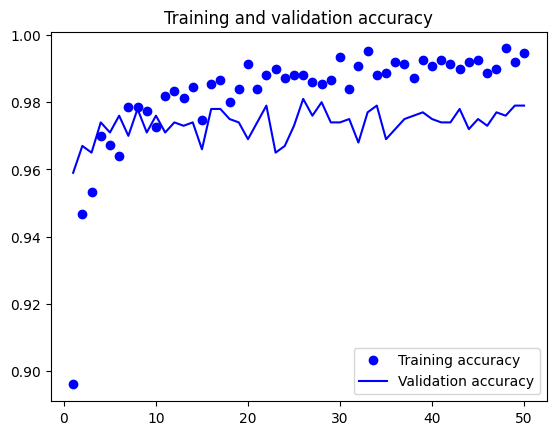

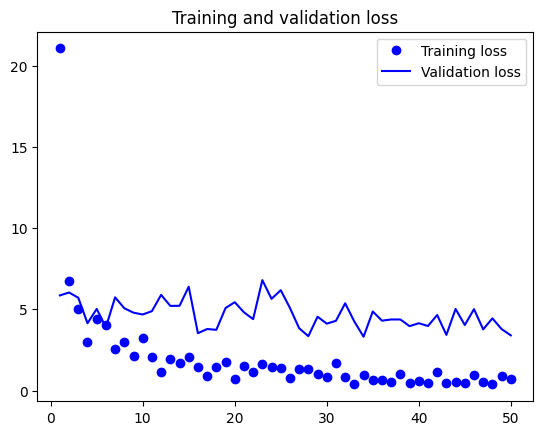

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
"feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.9648 - loss: 7.1997
Test accuracy: 0.973


barely higher than without data augmentation.

going to lower to 300, as data augmentation test acc actually went down.

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=300)
copy_images("validation")
copy_images("test")

 train/cats: 300 images copied
 train/dogs: 300 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 600 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
      preprocessed_images = keras.applications.vgg16.preprocess_input(images)
      features = conv_base.predict(preprocessed_images)
      all_features.append(features)
      all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
train_features.shape

(600, 5, 5, 512)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
      optimizer="rmsprop",
      metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7452 - loss: 90.3105 - val_accuracy: 0.9630 - val_loss: 3.8810
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9846 - loss: 1.5736 - val_accuracy: 0.9590 - val_loss: 3.8852
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9964 - loss: 0.4819 - val_accuracy: 0.9600 - val_loss: 4.8883
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9899 - loss: 1.0937 - val_accuracy: 0.9490 - val_loss: 8.6762
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9575 - loss: 6.3739 - val_accuracy: 0.9650 - val_loss: 5.6134
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9965 - loss: 0.2185 - val_accuracy: 0.9630 - val_loss: 6.7140
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9907 - loss: 0.7766 - val_accuracy: 0.9610 - val_loss: 8.8536
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9944 - loss: 1.5453 - val_accuracy: 0.9610 -

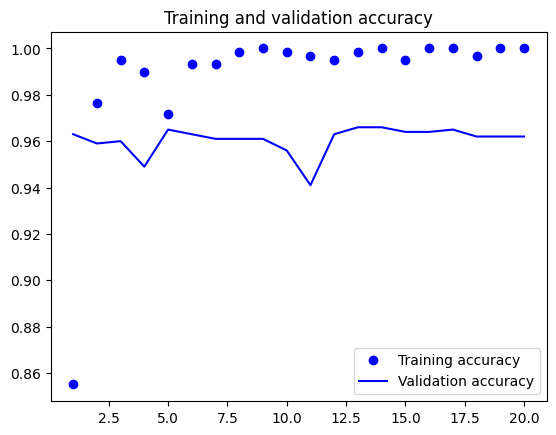

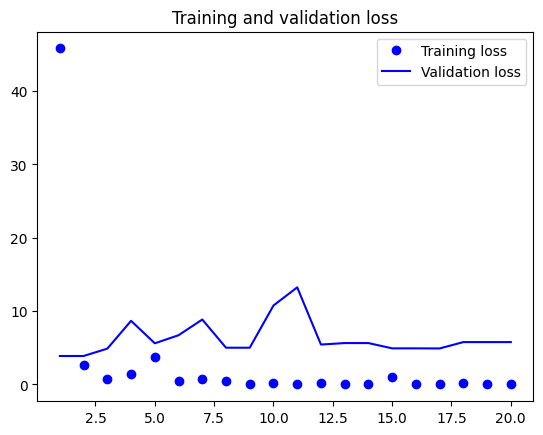

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")

test_features, test_labels = get_features_and_labels(test_dataset)

test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

with data augmentation

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=300)
copy_images("validation")
copy_images("test")

 train/cats: 300 images copied
 train/dogs: 300 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
  "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
  "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)


Found 600 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
filepath="feature_extraction_with_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 547ms/step - accuracy: 0.7305 - loss: 96.7949 - val_accuracy: 0.9690 - val_loss: 3.7175
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 324ms/step - accuracy: 0.9343 - loss: 6.2081 - val_accuracy: 0.9430 - val_loss: 8.7293
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - accuracy: 0.9381 - loss: 6.0013 - val_accuracy: 0.9650 - val_loss: 4.7130
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.9581 - loss: 4.0122 - val_accuracy: 0.9770 - val_loss: 1.7307
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.9656 - loss: 3.5790 - val_accuracy: 0.9660 - val_loss: 4.8861
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 397ms/step - accuracy: 0.9446 - loss: 5.5477 - val_accuracy: 0.9630 - val_loss: 4.7537
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 397ms/step - accuracy: 0.9682 - loss: 3.5895 - val_accuracy: 0.9750 - val_loss: 4.7130
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - accuracy: 0.9630 - loss: 4.5423 - val_accuracy:

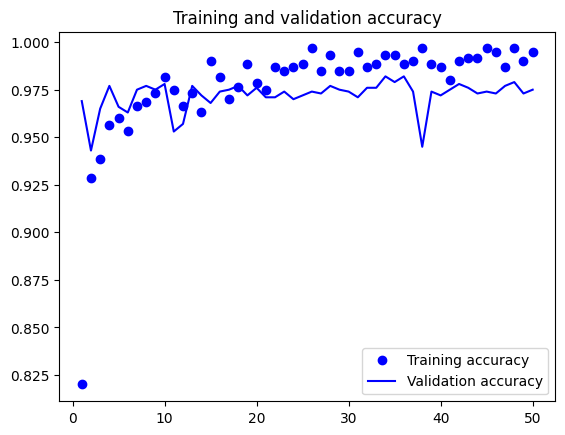

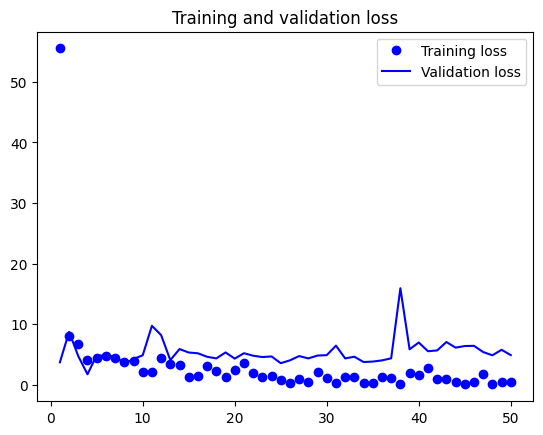

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
"feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9566 - loss: 5.7866
Test accuracy: 0.956


300 with data augmentation + layer freezing

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=300)
copy_images("validation")
copy_images("test")

 train/cats: 300 images copied
 train/dogs: 300 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)


Found 600 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

In [ ]:
model.compile(loss="binary_crossentropy",
      optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
      metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
filepath="fine_tuning.keras",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 359ms/step - accuracy: 0.6340 - loss: 6.8842 - val_accuracy: 0.8350 - val_loss: 1.7702
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - accuracy: 0.7966 - loss: 2.5688 - val_accuracy: 0.8950 - val_loss: 0.9708
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.8509 - loss: 1.6592 - val_accuracy: 0.9230 - val_loss: 0.7561
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.8872 - loss: 1.1060 - val_accuracy: 0.9330 - val_loss: 0.6764
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.9067 - loss: 0.8149 - val_accuracy: 0.9390 - val_loss: 0.5453
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.9208 - loss: 0.7555 - val_accuracy: 0.9480 - val_loss: 0.4971
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 438ms/step - accuracy: 0.9077 - loss: 0.6029 - val_accuracy: 0.9530 - val_loss: 0.4392
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.9280 - loss: 0.4525 - val_accuracy

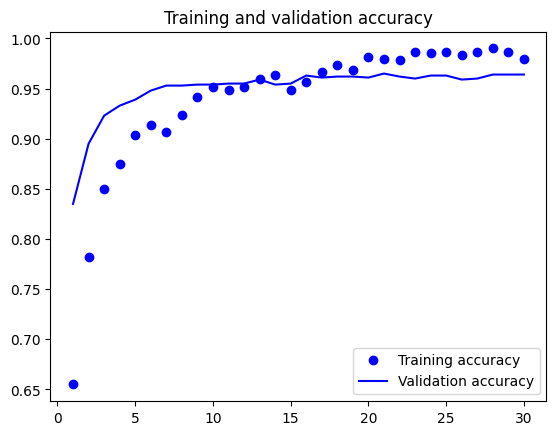

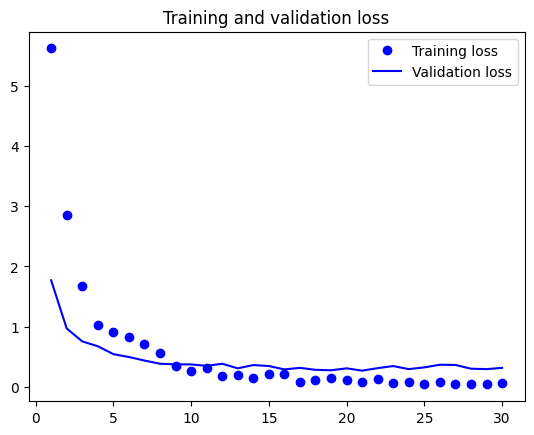

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9586 - loss: 0.3418
Test accuracy: 0.961


With 600

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=600)
copy_images("validation")
copy_images("test")

 train/cats: 600 images copied
 train/dogs: 600 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 1200 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
      preprocessed_images = keras.applications.vgg16.preprocess_input(images)
      features = conv_base.predict(preprocessed_images)
      all_features.append(features)
      all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
train_features.shape

(1200, 5, 5, 512)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
      optimizer="rmsprop",
      metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.7983 - loss: 68.3768 - val_accuracy: 0.9510 - val_loss: 10.0253
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9803 - loss: 2.4773 - val_accuracy: 0.9650 - val_loss: 4.4211
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9782 - loss: 2.0594 - val_accuracy: 0.9620 - val_loss: 6.2701
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9941 - loss: 0.4775 - val_accuracy: 0.9590 - val_loss: 9.2124
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9893 - loss: 2.1930 - val_accuracy: 0.9680 - val_loss: 5.7509
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9959 - loss: 0.5812 - val_accuracy: 0.9670 - val_loss: 4.6124
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.2594 - val_accuracy: 0.9640 - val_loss: 8.1727
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9968 - loss: 0.2276 - val_accuracy: 0.9610 - val

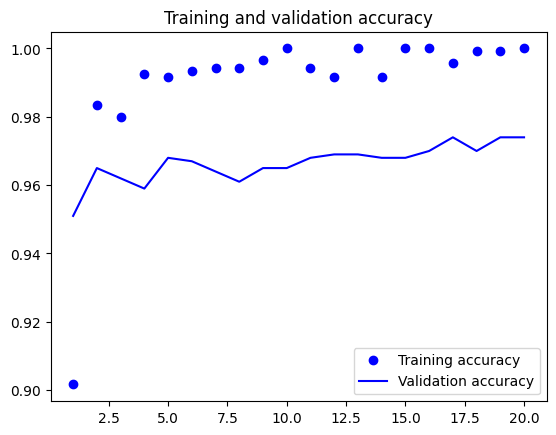

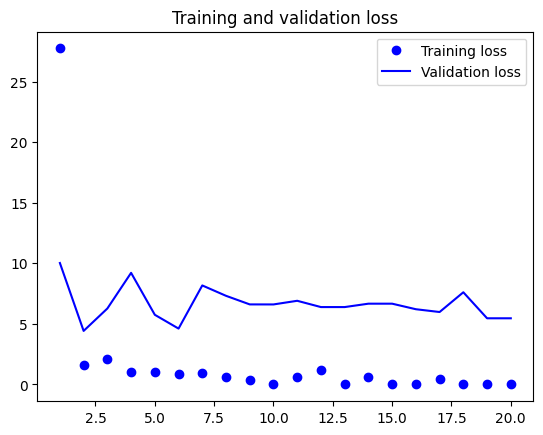

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")

test_features, test_labels = get_features_and_labels(test_dataset)

test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
with data augmentation + layer freezing

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=600)
copy_images("validation")
copy_images("test")

 train/cats: 600 images copied
 train/dogs: 600 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)


Found 1200 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

In [ ]:
model.compile(loss="binary_crossentropy",
      optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
      metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
filepath="fine_tuning.keras",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 321ms/step - accuracy: 0.5544 - loss: 8.5853 - val_accuracy: 0.8640 - val_loss: 1.3036
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step - accuracy: 0.7711 - loss: 3.0195 - val_accuracy: 0.9150 - val_loss: 0.7106
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 228ms/step - accuracy: 0.8410 - loss: 1.2215 - val_accuracy: 0.9320 - val_loss: 0.5261
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 306ms/step - accuracy: 0.8849 - loss: 0.6845 - val_accuracy: 0.9370 - val_loss: 0.4336
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.8893 - loss: 0.5072 - val_accuracy: 0.9440 - val_loss: 0.3934
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.9347 - loss: 0.3750 - val_accuracy: 0.9510 - val_loss: 0.3314
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 242ms/step - accuracy: 0.9201 - loss: 0.3650 - val_accuracy: 0.9580 - val_loss: 0.3230
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.9280 - loss: 0.3016 - val_accu

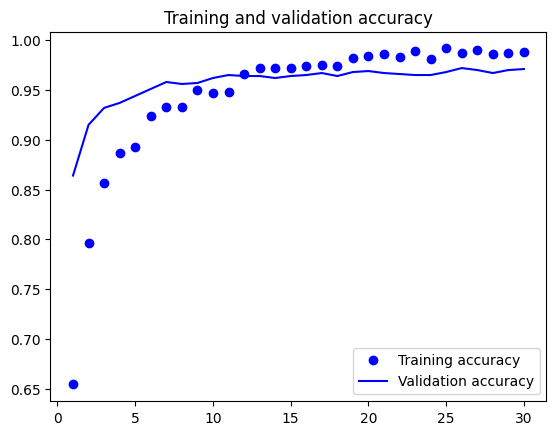

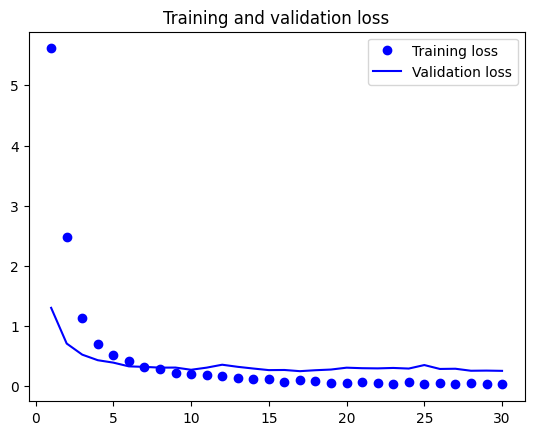

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9682 - loss: 0.3006
Test accuracy: 0.968


considering increase from 300, will try with full 1000.

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=1000)
copy_images("validation")
copy_images("test")

 train/cats: 1000 images copied
 train/dogs: 1000 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
      preprocessed_images = keras.applications.vgg16.preprocess_input(images)
      features = conv_base.predict(preprocessed_images)
      all_features.append(features)
      all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
train_features.shape

(2000, 5, 5, 512)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
      optimizer="rmsprop",
      metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8844 - loss: 15.4269 - val_accuracy: 0.9740 - val_loss: 2.9135
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9724 - loss: 3.5009 - val_accuracy: 0.9500 - val_loss: 8.3972
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9800 - loss: 2.6000 - val_accuracy: 0.9650 - val_loss: 6.8212
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9901 - loss: 1.4909 - val_accuracy: 0.9700 - val_loss: 5.5685
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9953 - loss: 0.4244 - val_accuracy: 0.9710 - val_loss: 5.3788
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9898 - loss: 1.5978 - val_accuracy: 0.9790 - val_loss: 4.6983
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9973 - loss: 0.4293 - val_accuracy: 0.9700 - val_loss: 4.1900
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9990 - loss: 0.1597 - val_accuracy: 0.9740 - val_los

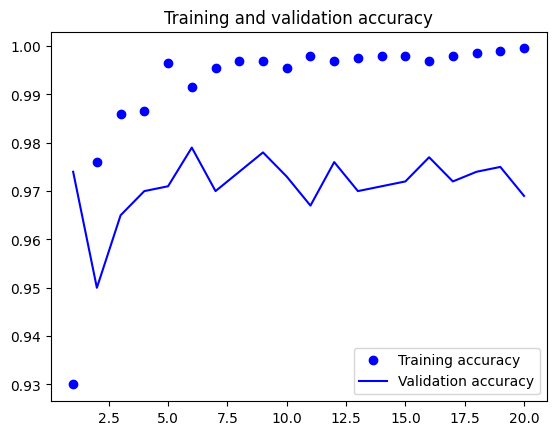

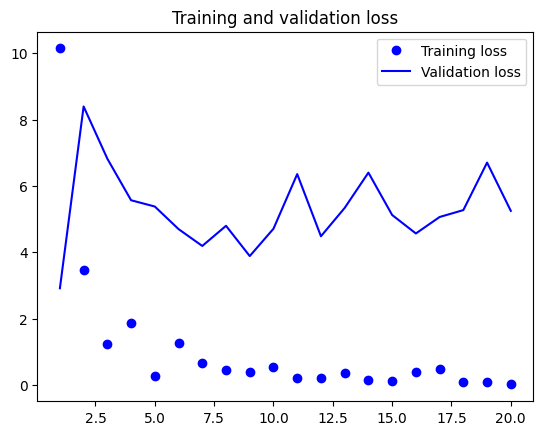

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")

test_features, test_labels = get_features_and_labels(test_dataset)

test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1000 with data augmentation + layer freezing

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=1000)
copy_images("validation")
copy_images("test")

 train/cats: 1000 images copied
 train/dogs: 1000 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

In [ ]:
model.compile(loss="binary_crossentropy",
      optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
      metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
filepath="fine_tuning.keras",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 238ms/step - accuracy: 0.6169 - loss: 6.6235 - val_accuracy: 0.9120 - val_loss: 0.6966
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 212ms/step - accuracy: 0.8175 - loss: 1.4338 - val_accuracy: 0.9450 - val_loss: 0.3165
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.8745 - loss: 0.8108 - val_accuracy: 0.9540 - val_loss: 0.2636
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9113 - loss: 0.3558 - val_accuracy: 0.9620 - val_loss: 0.2329
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.9181 - loss: 0.3429 - val_accuracy: 0.9580 - val_loss: 0.2001
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.9435 - loss: 0.1918 - val_accuracy: 0.9610 - val_loss: 0.2026
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.9407 - loss: 0.1607 - val_accuracy: 0.9650 - val_loss: 0.1730
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.9687 - loss: 0.1202 - val_accu

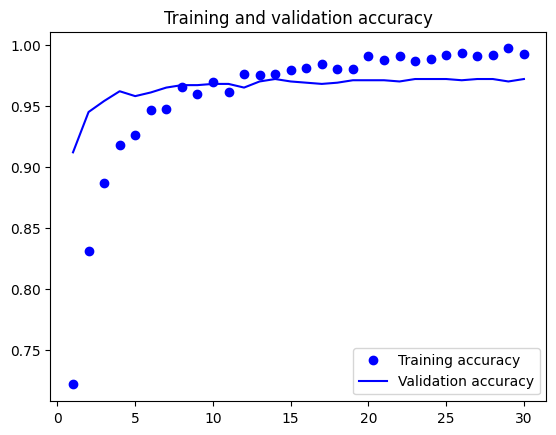

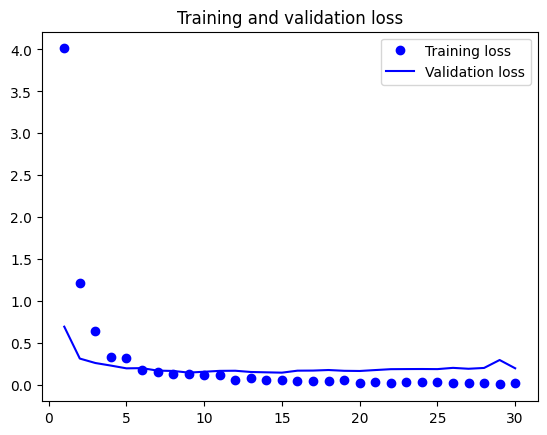

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.9630 - loss: 0.2161
Test accuracy: 0.969


no improvement.

1000 with just data augmentation-

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=1000)
copy_images("validation")
copy_images("test")

 train/cats: 1000 images copied
 train/dogs: 1000 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
  "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
  "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
filepath="feature_extraction_with_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 351ms/step - accuracy: 0.8294 - loss: 25.5422 - val_accuracy: 0.9680 - val_loss: 4.6582
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 191ms/step - accuracy: 0.9447 - loss: 7.4783 - val_accuracy: 0.9760 - val_loss: 4.0712
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 0.9472 - loss: 5.7830 - val_accuracy: 0.9630 - val_loss: 7.4858
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.9492 - loss: 5.8338 - val_accuracy: 0.9790 - val_loss: 3.8654
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - accuracy: 0.9736 - loss: 3.8458 - val_accuracy: 0.9790 - val_loss: 3.3336
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.9672 - loss: 3.9799 - val_accuracy: 0.9750 - val_loss: 4.4528
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.9648 - loss: 4.2187 - val_accuracy: 0.9780 - val_loss: 3.0884
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.9724 - loss: 2.8668 - val_acc

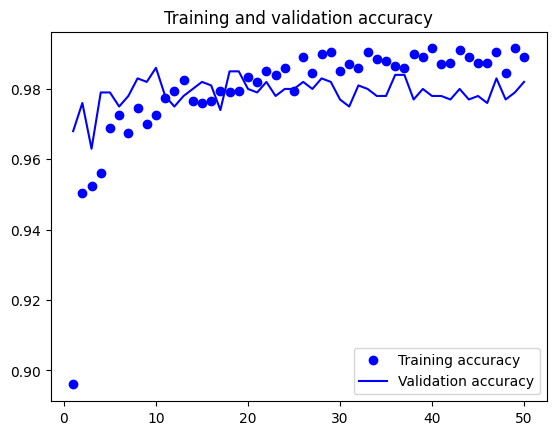

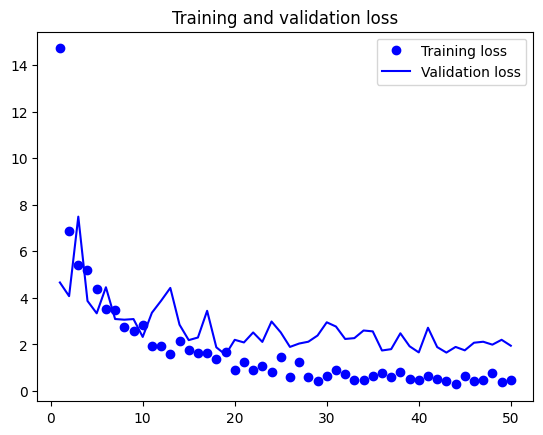

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
"feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9833 - loss: 1.9927
Test accuracy: 0.980


Highest test accuracy so far. Will go ahead and try 1000 with all layers true.

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=1000)
copy_images("validation")
copy_images("test")

 train/cats: 1000 images copied
 train/dogs: 1000 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = True

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
filepath="feature_extraction_with_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - accuracy: 0.4710 - loss: 91464.3672 - val_accuracy: 0.5020 - val_loss: 0.6932
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 379ms/step - accuracy: 0.5188 - loss: 0.8370 - val_accuracy: 0.5030 - val_loss: 0.6931
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 349ms/step - accuracy: 0.5063 - loss: 0.7102 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 341ms/step - accuracy: 0.4941 - loss: 2.6309 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 355ms/step - accuracy: 0.5066 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 343ms/step - accuracy: 0.5043 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 7/50


KeyboardInterrupt: 

600 with aug only

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=600)
copy_images("validation")
copy_images("test")

 train/cats: 600 images copied
 train/dogs: 600 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
  "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 0


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)


Found 1200 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
filepath="feature_extraction_with_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.8184 - loss: 34.6333 - val_accuracy: 0.9430 - val_loss: 10.0186
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.9494 - loss: 7.8661 - val_accuracy: 0.9630 - val_loss: 5.2827
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.9484 - loss: 5.0215 - val_accuracy: 0.9230 - val_loss: 19.5298
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 296ms/step - accuracy: 0.9595 - loss: 6.8268 - val_accuracy: 0.9610 - val_loss: 8.7278
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.9639 - loss: 4.7521 - val_accuracy: 0.9720 - val_loss: 4.8216
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - accuracy: 0.9743 - loss: 2.7167 - val_accuracy: 0.9710 - val_loss: 5.6886
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.9677 - loss: 4.4760 - val_accuracy: 0.9710 - val_loss: 5.6289
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.9736 - loss: 2.7618 - val_acc

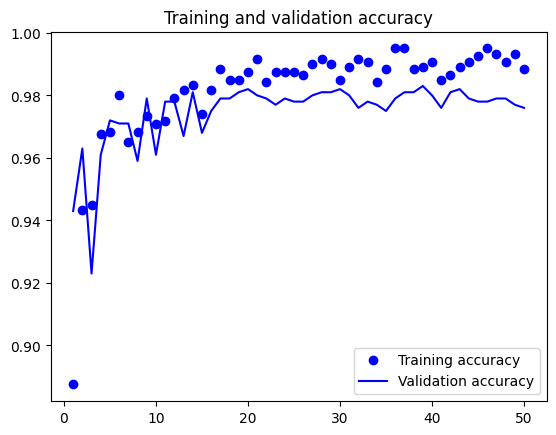

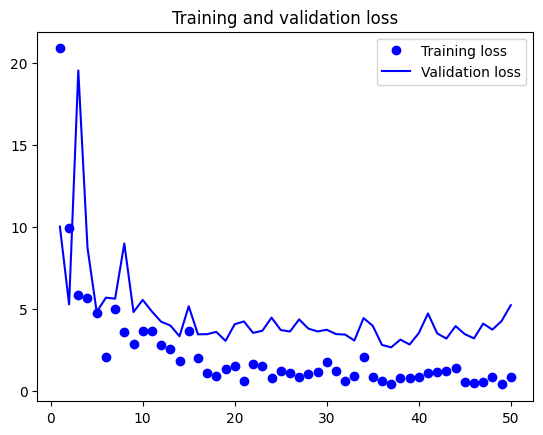

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
"feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9652 - loss: 6.5149
Test accuracy: 0.969


In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=500)
copy_images("validation")
copy_images("test")

 train/cats: 500 images copied
 train/dogs: 500 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)


Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

In [ ]:
model.compile(loss="binary_crossentropy",
      optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
      metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
filepath="fine_tuning.keras",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - accuracy: 0.6391 - loss: 7.2602 - val_accuracy: 0.8860 - val_loss: 1.2422
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.8272 - loss: 1.8086 - val_accuracy: 0.9220 - val_loss: 0.7618
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 302ms/step - accuracy: 0.8708 - loss: 1.4148 - val_accuracy: 0.9410 - val_loss: 0.5817
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - accuracy: 0.8996 - loss: 0.9701 - val_accuracy: 0.9420 - val_loss: 0.4509
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.9147 - loss: 0.6263 - val_accuracy: 0.9520 - val_loss: 0.4112
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - accuracy: 0.9273 - loss: 0.4984 - val_accuracy: 0.9550 - val_loss: 0.3596
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.9224 - loss: 0.6225 - val_accuracy: 0.9590 - val_loss: 0.3564
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.9512 - loss: 0.3285 - val_accura

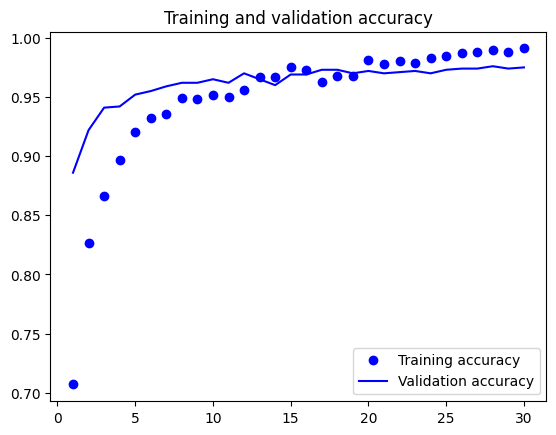

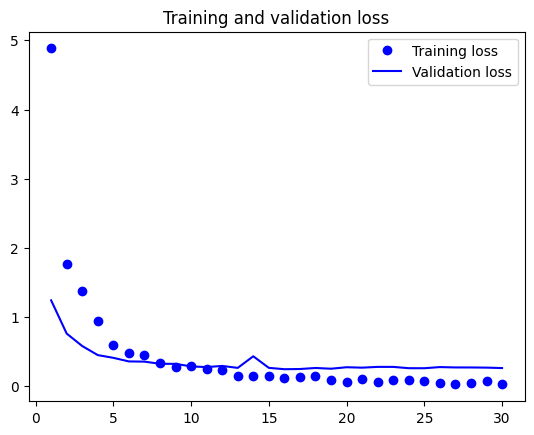

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9675 - loss: 0.2507
Test accuracy: 0.972


750 with aug + freezing

In [ ]:
from pathlib import Path
import shutil
import os
import random

original_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small/cats_vs_dogs_small")
new_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_subset")

subsets = ["train", "validation", "test"]
categories = ["cats", "dogs"]

for subset in subsets:
    for category in categories:
        subset_dir = new_base_dir / subset / category
        if subset_dir.exists():
            shutil.rmtree(subset_dir)
        subset_dir.mkdir(parents=True, exist_ok=True)

def copy_images(subset_name, limit=None):
    for category in categories:
        src_dir = original_dir / subset_name / category
        dst_dir = new_base_dir / subset_name / category

        if not src_dir.exists():
            print(f"{src_dir} does not exist")
            continue

        all_files = sorted(list(src_dir.glob("*.jpg")))
        if limit:
            all_files = random.sample(all_files, min(limit, len(all_files)))

        files_copied = 0
        for file_path in all_files:
            shutil.copy(file_path, dst_dir)
            files_copied += 1

        print(f" {subset_name}/{category}: {files_copied} images copied")

copy_images("train", limit=750)
copy_images("validation")
copy_images("test")

 train/cats: 750 images copied
 train/dogs: 750 images copied
 validation/cats: 500 images copied
 validation/dogs: 500 images copied
 test/cats: 500 images copied
 test/dogs: 500 images copied


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)


Found 1500 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

In [ ]:
model.compile(loss="binary_crossentropy",
      optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
      metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
filepath="fine_tuning.keras",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 418ms/step - accuracy: 0.6581 - loss: 6.8988 - val_accuracy: 0.8980 - val_loss: 0.9681
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - accuracy: 0.8280 - loss: 1.8276 - val_accuracy: 0.9480 - val_loss: 0.5188
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.8807 - loss: 0.9508 - val_accuracy: 0.9520 - val_loss: 0.3861
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 0.9087 - loss: 0.5147 - val_accuracy: 0.9620 - val_loss: 0.3072
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 0.9228 - loss: 0.4139 - val_accuracy: 0.9650 - val_loss: 0.3139
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step - accuracy: 0.9302 - loss: 0.4037 - val_accuracy: 0.9690 - val_loss: 0.2488
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.9481 - loss: 0.2350 - val_accuracy: 0.9670 - val_loss: 0.2531
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.9566 - loss: 0.2068 - val_accu

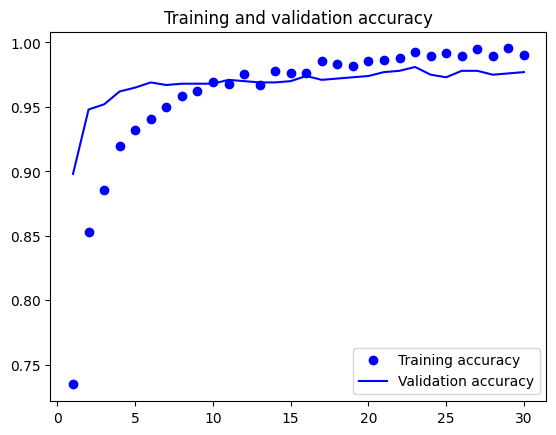

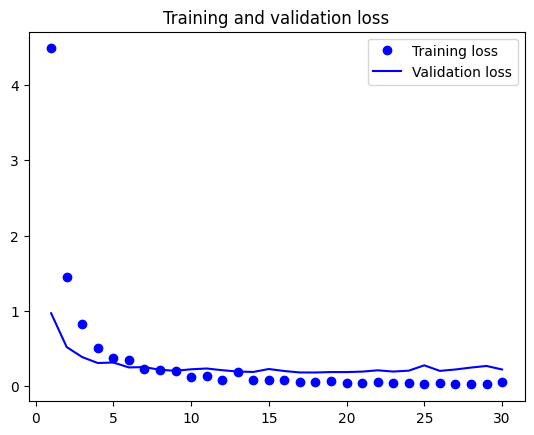

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9761 - loss: 0.1672
Test accuracy: 0.974
